<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Simple_Moving_Average(SMA)_Crossover_Algorithmic_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import quandl
import datetime
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# **1. Fetch stock data**

In [0]:
def get_data(ticker, start_date, end_date, csv_file_name):
    if os.path.exists(csv_file_name):
        all_data = pd.read_csv(csv_file_name,  index_col=['Date'], header =0, parse_dates=True)
        print("Read tickers data from file:", csv_file_name)
        return all_data
    else:
        quandl.ApiConfig.api_key = "CG7axqyftyamjMa2DPB5"
        ticker_data = quandl.get('WIKI/'+ticker, start_date = start_date, end_date = end_date)
        ticker_data.to_csv(csv_file_name)
        return ticker_data

# **2. Formulate SMA strategy**

In [3]:
short_lookback_period = 40 # days
long_lookback_period = 100 # days

apple_ticker_data = get_data('AAPL', '2006-10-01', '2012-01-01', "apple_ticker_data.csv")

# Prepare a signal dataframe with Date same as from apple ticker data
signals = pd.DataFrame(index=apple_ticker_data.index)
signals['signal'] = 0.0

# Short moving average 
signals['short_mavg'] = apple_ticker_data['Close'].rolling(window=short_lookback_period, min_periods=1, center=False).mean()

# Long moving average
signals['long_mavg'] = apple_ticker_data['Close'].rolling(window=long_lookback_period, min_periods = 1, center=False).mean()

# Identify cross overs
# when short moving avg is greater than long moving avg
signals['signal'][short_lookback_period:] = np.where(signals['short_mavg'][short_lookback_period:] > signals['long_mavg'][short_lookback_period:], 
                             1.0, 0.0) # Value 1 if True, Value 0 if False

signals['position'] = signals['signal'].diff()

# Where position is 1
display(signals[signals.position == 1.0].head())
        
# Where position is -1
display(signals[signals.position == -1].head())

,signal,short_mavg,long_mavg,position
Date,,,,
2006-11-28,1.0,80.767000,80.622927,1.0
2008-05-06,1.0,152.380005,151.988421,1.0
2009-03-19,1.0,92.959187,92.698375,1.0
2010-09-17,1.0,256.361775,256.145530,1.0
2011-05-12,1.0,342.916562,342.858125,1.0


,signal,short_mavg,long_mavg,position
Date,,,,
2008-02-06,0.0,169.159560,169.198359,-1.0
2008-08-11,0.0,168.866250,169.257402,-1.0
2010-08-24,0.0,254.509000,254.852425,-1.0
2011-05-11,0.0,342.502562,342.598525,-1.0
2011-05-16,0.0,343.128812,343.131975,-1.0


# **3. Visualize moving averages and cross-over points**

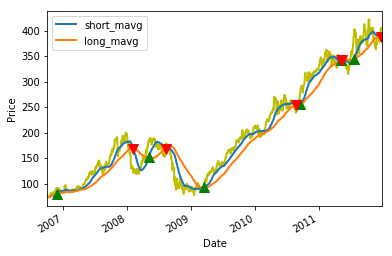

In [4]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel = 'Price')

# Plot the closing prices
apple_ticker_data['Close'].plot(ax=ax1, color = 'y', lw=2)

# Plot the short and long moving average
signals[['short_mavg','long_mavg']].plot(ax=ax1, lw=2)

# Plot the buy signal
ax1.plot(signals.loc[signals.position == 1.0].index,
         signals.short_mavg[signals.position == 1.0], 
         marker = '^', markersize = 10, color='g', lw=0)

# Plot the sell signal
ax1.plot(signals.loc[signals.position == -1.0].index,
         signals.short_mavg[signals.position == -1.0], 
         marker = 'v', markersize = 10, color='r', lw=0)

plt.show()

# **4. Backtesting the SMA cross-over strategy**

In [5]:
# Simple Backtester

# Initial capital
initial_capital = 100000

# Positions Dataframe
positions = pd.DataFrame(index = signals.index)

# Buy 100 shares
positions['AAPL'] = 100 * signals['signal']

# Initialize the portfolio with values of shares owned
portfolio = positions.multiply(apple_ticker_data['Adj. Close'], axis=0)

# Stores the difference in shares owned
pos_diff = positions.diff()

# Add holdings to portfolio
portfolio['holdings'] = (positions.multiply(apple_ticker_data['Adj. Close'], axis=0)).sum(axis=1)

# Add cash to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(apple_ticker_data['Adj. Close'], axis=0)).sum(axis=1).cumsum()

# Total portfolio worth
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# portfolio returns
portfolio['returns'] = portfolio['total'].pct_change()
print(portfolio.tail())

                   AAPL     holdings           cash          total   returns
Date                                                                        
2011-12-23  5183.352647  5183.352647   97695.616584  102878.969231  0.000597
2011-12-27     0.000000     0.000000  102920.093691  102920.093691  0.000400
2011-12-28     0.000000     0.000000  102920.093691  102920.093691  0.000000
2011-12-29     0.000000     0.000000  102920.093691  102920.093691  0.000000
2011-12-30     0.000000     0.000000  102920.093691  102920.093691  0.000000


# **5. Visualizing portfolio constructed during backtesting using SMA cross-over strategy**

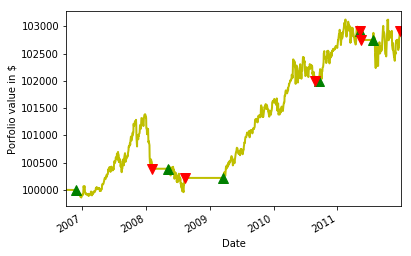

In [6]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel = "Porfolio value in $")

portfolio['total'].plot(ax = ax1, color = 'y', lw=2.0)

# Plot the portfolio on buy signal
ax1.plot(portfolio.loc[signals.position == 1.0].index,
         portfolio.total[signals.position == 1.0], 
         marker = '^', markersize = 10, color='g', lw=0)

# Plot the portfolio on sell signal
ax1.plot(portfolio.loc[signals.position == -1.0].index,
         portfolio.total[signals.position == -1.0], 
         marker = 'v', markersize = 10, color='r', lw=0)

# **6. Evaluating performance of SMA cross-over strategy**

**A. Sharpe Ratio**

In [7]:
returns = portfolio['returns']

# annualized sharpe ratio
sharpe_ratio = np.sqrt(252)*(returns.mean()/returns.std())

print(sharpe_ratio)

0.7261238825870256


**B. Compound Annualized Growth Rate - CAGR**

In [8]:
days = (apple_ticker_data.index[-1]-apple_ticker_data.index[0]).days
cagr = apple_ticker_data['Adj. Close'][-1] - apple_ticker_data['Adj. Close'][1]
cagr **= (365.0/days)
cagr -= 1
print(cagr)

1.043753306250188
